In [1]:
import os
import itertools
import random

from replay_loading import enum_replay_folder, files_to_strokes, sample_stroke

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler, WeightedRandomSampler
import pickle
from typing import Iterator, List, Tuple, Dict, Any, Optional, Union, Iterable, Callable
from tqdm import tqdm
from multiprocessing import Pool

# import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

In [2]:
replay_fns = list(itertools.islice(enum_replay_folder("H:/osu!/Data/r/"), 300))
strokes_subset = list(files_to_strokes(tqdm(replay_fns), min_length=50))
sum((len(s[0]) for s in strokes_subset))

  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [00:15<00:00, 19.59it/s]


1940603

In [3]:
# all_replays = list(enum_replay_folder("H:/osu!/Data/r/"))
# all_strokes = list(files_to_strokes(tqdm(all_replays), min_length=50))
# pickle.dump(all_strokes, open("all_strokes.pkl", "wb"))

In [4]:
all_strokes = pickle.load(open("all_strokes.pkl", "rb"))

In [5]:
class StrokeDataset(Dataset):
    def __init__(self, strokes, transforms=None):
        self.strokes = strokes
        self.transforms = transforms
        self.wrand_sampler = WeightedRandomSampler([len(s[0]) for s in strokes], len(strokes), replacement=True)

    def __len__(self):
        return len(self.strokes)

    def __getitem__(self, idx):
        sample = self.strokes[idx]
        
        # Apply the transformations if any
        if self.transforms:
            for transform in self.transforms:
                sample = transform(sample)
            return sample
        else:
            return sample[1]


class StrokeResample:
    def __init__(self, rate_range=(30, 250), max_length=2048):
        self.rate_range = rate_range
        self.max_length = max_length

    def __call__(self, sample):
        timings, positions = sample
        rate = np.random.uniform(*self.rate_range)
        offset = np.random.uniform(0, 1/rate)
        return sample_stroke(timings, positions, rate, offset, max_length=self.max_length)


class StrokeDiff:
    def __call__(self, sample):
        return np.diff(sample, axis=0)


class ScaleRotateFlip:
    def __init__(self, scale_range=(0.5, 1.5)):
        self.scale_range = scale_range

    def __call__(self, sample):
        scale = random.uniform(*self.scale_range)
        sample = sample * scale
        angle = random.uniform(-np.pi, np.pi)
        flip = random.choice([1, -1])
        rotation_matrix = np.array([
            [np.cos(angle), -flip * np.sin(angle)],
            [flip * np.sin(angle), np.cos(angle)]])
        sample = sample @ rotation_matrix
        return sample


class StrokeToTensor:
    def __call__(self, sample):
        return torch.from_numpy(sample).float()


def collate_pad_beginning_zeroes(batch):
    max_len = max([len(stroke) for stroke in batch])
    padded_batch = [F.pad(stroke, (0, 0, max_len - len(stroke), 0)) for stroke in batch]
    return torch.stack(padded_batch)


transforms = [
    StrokeResample(max_length=4096),
    StrokeDiff(),
    ScaleRotateFlip(),
    StrokeToTensor(),
]

batch_size = 1024

ds_small = StrokeDataset(strokes_subset, transforms=transforms)
ds_small_loader = DataLoader(ds_small, batch_size=batch_size, sampler=ds_small.wrand_sampler, collate_fn=collate_pad_beginning_zeroes)

ds_full = StrokeDataset(all_strokes, transforms=transforms)
ds_full_loader = DataLoader(ds_full, batch_size=batch_size, sampler=ds_full.wrand_sampler, collate_fn=collate_pad_beginning_zeroes)

In [6]:
class TestNet3(nn.Module):
    def __init__(self, kernels=[5]*12, channels=[8]*4+[4]*4+[2]*4):
        # input is (batch, seq_len, 2)
        super().__init__()
        # let's organize channels in a densenet style thingy
        # also use glu activations, because why not, lol
        channels = [2] + channels + [2]
        in_channels = []
        for i in range(len(channels)):
            in_channels.append(sum(channels[:i]))
        
        channels = channels[1:]
        in_channels = in_channels[1:]
        kernels = kernels + [1]
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels[i], channels[i]*2, kernels[i]) for i in range(len(kernels))
        ])
        self.pads = [kernel - 1 for kernel in kernels]
        self.pad_total = sum(self.pads)
    
    def forward(self, x):
        x = x.transpose(1, 2) # (batch, 2, seq_len)
        acts = [x] # to remove padding
        curr_window = x.shape[-1]
        for i, conv in enumerate(self.convs):
            x = conv(torch.cat([act[..., -curr_window:] for act in acts], dim=1))
            x = F.glu(x, dim=1)
            curr_window -= self.pads[i]
            acts.append(x)
        x = x.transpose(1, 2)
        return x

sum(p.numel() for p in TestNet3().parameters() if p.requires_grad)

15468

In [7]:
model = TestNet3().cuda()
unpad = model.pad_total + 1
optimizer = optim.AdamW(model.parameters(), lr=0.002)

losses = []
losses_verbose = []

Epoch 1, Loss: 0.44953093232085173, LR: 0.002
Epoch 2, Loss: 0.34303669393334757, LR: 0.0019782568627301367
Epoch 3, Loss: 0.3311870024628835, LR: 0.001913977730354388
Epoch 4, Loss: 0.3242582414792553, LR: 0.0018099719094030729
Epoch 5, Loss: 0.32073684043535905, LR: 0.001670784953327064
Epoch 6, Loss: 0.3191044957942614, LR: 0.0015025000000000001
Epoch 7, Loss: 0.31406885616855534, LR: 0.001312471909403073
Epoch 8, Loss: 0.3133243361836699, LR: 0.0011090058209513155
Epoch 9, Loss: 0.31210501553261116, LR: 0.0009009941790486852
Epoch 10, Loss: 0.30982399231767, LR: 0.0006975280905969276
Epoch 11, Loss: 0.3086406883855933, LR: 0.0005075000000000004
Epoch 12, Loss: 0.30876240324756327, LR: 0.0003392150466729365
Epoch 13, Loss: 0.3082072319777589, LR: 0.0002000280905969274
Epoch 14, Loss: 0.307745879235333, LR: 9.602226964561204e-05
Epoch 15, Loss: 0.3079202459555238, LR: 3.174313726986335e-05


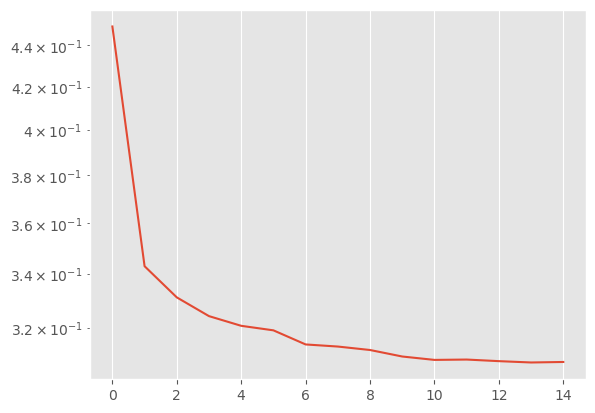

In [8]:
n_epochs = 15
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs, eta_min=0.00001)

for epoch in range(n_epochs):  # number of epochs
    epoch_losses = []

    for batch in ds_full_loader:
        # Zero the gradients
        optimizer.zero_grad()

        batch = batch.cuda()

        # Forward pass
        outputs = model(batch[:, :-1, :])

        # Compute loss
        loss = F.huber_loss(outputs, batch[:, unpad:, :])

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())
    
    epoch_loss = np.mean(epoch_losses)
    losses.append(epoch_loss)
    losses_verbose.append(epoch_losses)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss}, LR: {scheduler.get_last_lr()[0]}")

    # Update the learning rate
    scheduler.step()

plt.plot(losses)
plt.yscale('log')

In [12]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [11]:
model.cpu()
# torch.save(model.state_dict(), "model1.pth")

In [7]:
model = TestNet3()
model.load_state_dict(torch.load("model1.pth"))
model

TestNet3(
  (convs): ModuleList(
    (0): Conv1d(2, 16, kernel_size=(5,), stride=(1,))
    (1): Conv1d(10, 16, kernel_size=(5,), stride=(1,))
    (2): Conv1d(18, 16, kernel_size=(5,), stride=(1,))
    (3): Conv1d(26, 16, kernel_size=(5,), stride=(1,))
    (4): Conv1d(34, 8, kernel_size=(5,), stride=(1,))
    (5): Conv1d(38, 8, kernel_size=(5,), stride=(1,))
    (6): Conv1d(42, 8, kernel_size=(5,), stride=(1,))
    (7): Conv1d(46, 8, kernel_size=(5,), stride=(1,))
    (8): Conv1d(50, 4, kernel_size=(5,), stride=(1,))
    (9): Conv1d(52, 4, kernel_size=(5,), stride=(1,))
    (10): Conv1d(54, 4, kernel_size=(5,), stride=(1,))
    (11): Conv1d(56, 4, kernel_size=(5,), stride=(1,))
    (12): Conv1d(58, 4, kernel_size=(1,), stride=(1,))
  )
)

In [8]:
model.pad_total

48

In [10]:
x = torch.zeros(1, model.pad_total + 1, 2)
x[:, -2, :] = torch.tensor([-0.05, 0.05])
x[:, -1, :] = torch.tensor([-0.1, 0.1])
model(x)

tensor([[[-0.1093,  0.1120]]], grad_fn=<TransposeBackward0>)

In [35]:
model.cpu()
x = x.cpu()

In [36]:
%timeit model(x)

2.06 ms ± 32.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [37]:
torch.export.export(model, (x,))

RuntimeError: Windows not yet supported for torch.compile

In [13]:
torch.onnx.export(model, x, "model1.onnx")#, verbose=True)

In [18]:
torch.onnx.export(model, torch.rand(4, 49, 2), "model2.onnx")

In [16]:
torch.onnx.dynamo_export(model, x, export_options=torch.onnx.ExportOptions(dynamic_shapes=True)).save("model3.onnx")

c:\Users\Abstract\mambaforge\envs\deepenv\Lib\site-packages\torch\onnx\_internal\exporter.py:137: UserWarning: torch.onnx.dynamo_export only implements opset version 18 for now. If you need to use a different opset version, please register them with register_custom_op.
  warnings.warn(


OnnxExporterError: Failed to export the model to ONNX. Generating SARIF report at 'report_dynamo_export.sarif'. SARIF is a standard format for the output of static analysis tools. SARIF logs can be loaded in VS Code SARIF viewer extension, or SARIF web viewer (https://microsoft.github.io/sarif-web-component/). Please report a bug on PyTorch Github: https://github.com/pytorch/pytorch/issues